<a href="https://colab.research.google.com/github/solharsh/Company_Project_Food_Safety/blob/master/Food_Safery_Amazon_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import nltk
import re
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics  import accuracy_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## Import GloVe
	
with open("/content/drive/My Drive/Capstone Project - NLP/NLP-master/nlp-getting-started/glove.6B.100d.txt", "r") as lines:	
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [5]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print( "Done.",len(model)," words loaded!")
    return model
w2v_v2 = loadGloveModel('/content/drive/My Drive/Capstone Project - NLP/NLP-master/nlp-getting-started/glove.6B.100d.txt')

Loading Glove Model
Done. 400000  words loaded!


In [6]:
len(w2v_v2['the'])

100

In [0]:
## Import Train and Test Data
train = pd.read_csv('/content/drive/My Drive/Food_Safety_Amazon/training.csv',sep=None, header=0, index_col=False, parse_dates=['Timestamp'],engine='python')
test = pd.read_csv('/content/drive/My Drive/Food_Safety_Amazon/public_test_features.csv',sep=None, header=0, index_col=False, parse_dates=['Timestamp'],engine='python')

In [0]:
## Special Characters 
regex = re.compile('[^a-zA-Z\']')

In [12]:
train.head(1)

,ID,Product ASIN,Review star rating,Food Safety Issue,Review Text,Review Title,@nlp.sentenceCount,@product.brand,@product.countryOfOrigin,Product Width,Product Length,Product Height,Timestamp,Product Title (Analyzed)
0,2024,B004DSMGXE,1,1,very stale! went into garbage....,went into garbage..,3,Ferrara,MX,NaN,NaN,NaN,2017-10-29 09:43:00,"Wrapped Vanilla Caramel Squares 2lb, 2 Pound"


In [18]:
## Import Stop Words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
## Lower Case All Text Data 
	
train['Review Text'] = train['Review Text'].apply(lambda x:str(x).lower())
train['Review Title'] = train['Review Title'].apply(lambda x:str(x).lower())
train['@product.brand'] = train['@product.brand'].apply(lambda x:str(x).lower())
train['Product Title (Analyzed)'] = train['Product Title (Analyzed)'].apply(lambda x:str(x).lower())
test['Review Text'] = test['Review Text'].apply(lambda x:str(x).lower())
test['Review Title'] = test['Review Title'].apply(lambda x:str(x).lower())
test['@product.brand'] = test['@product.brand'].apply(lambda x:str(x).lower())	
test['Product Title (Analyzed)'] = test['Product Title (Analyzed)'].apply(lambda x:str(x).lower())

## Remove Speical Characters
train['Review Text'] = train['Review Text'].apply(lambda x:regex.sub(' ',str(x)))
train['Review Title'] = train['Review Title'].apply(lambda x:regex.sub(' ',str(x)))
train['@product.brand'] = train['@product.brand'].apply(lambda x:regex.sub(' ',str(x)))
train['Product Title (Analyzed)'] = train['Product Title (Analyzed)'].apply(lambda x:regex.sub(' ',str(x)))
test['Review Text'] = test['Review Text'].apply(lambda x:regex.sub(' ',str(x)))
test['Review Title'] = test['Review Title'].apply(lambda x:regex.sub(' ',str(x)))
test['@product.brand'] = test['@product.brand'].apply(lambda x:regex.sub(' ',str(x)))
test['Product Title (Analyzed)'] = test['Product Title (Analyzed)'].apply(lambda x:regex.sub(' ',str(x)))

In [0]:
## Stop Word Remover from tokenized list
from nltk.tokenize import word_tokenize 
def removeStopWords(sentence):
    tok = word_tokenize(sentence)	
    return [w for w in tok if w not in stop_words]

## Adjective Tokenizer
def adjToken(sentence):
    return [e1 for (e1,e2) in nltk.pos_tag(nltk.word_tokenize(sentence)) if (e2 == 'JJ')|(e2=='JJS')|(e2=='JJR') ]

In [21]:
## Tokenize Text and Remove Stop Words
nltk.download('punkt')	
nltk.download('averaged_perceptron_tagger')
train['text token'] = train['Review Text'].apply(lambda x:removeStopWords(str(x)))
train['title token'] = train['Review Title'].apply(lambda x:removeStopWords(str(x)))
train['brand token'] = train['@product.brand'].apply(lambda x:removeStopWords(str(x)))
train['product title token'] = train['Product Title (Analyzed)'].apply(lambda x:removeStopWords(str(x)))
test['text token'] = test['Review Text'].apply(lambda x:removeStopWords(str(x)))
test['title token'] = test['Review Title'].apply(lambda x:removeStopWords(str(x)))
test['brand token'] = test['@product.brand'].apply(lambda x:removeStopWords(str(x)))
test['product title token'] = test['Product Title (Analyzed)'].apply(lambda x:removeStopWords(str(x)))
	
## Adjectives Only ##
train['adj token'] = train['Review Text'].apply(lambda x:adjToken(x))
test['adj token'] = test['Review Text'].apply(lambda x:adjToken(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
## Has Words like Stale, Not, Disappointed, Good -- and combinations 
	
train['has stale'] = train['text token'].apply(lambda x:(1 if 'stale' in x else 0))
train['has not'] = train['text token'].apply(lambda x:(1 if 'not' in x else 0))
train['has disappointed'] = train['text token'].apply(lambda x:(1 if 'disappointed' in x else 0))
train['has good'] = train['text token'].apply(lambda x:(1 if 'good' in x else 0))
train['has great'] = train['text token'].apply(lambda x:(1 if 'great' in x else 0))
	
test['has stale'] = test['text token'].apply(lambda x:(1 if 'stale' in x else 0))
test['has not'] = test['text token'].apply(lambda x:(1 if 'not' in x else 0))
test['has disappointed'] = test['text token'].apply(lambda x:(1 if 'disappointed' in x else 0))
test['has good'] = test['text token'].apply(lambda x:(1 if 'good' in x else 0))
test['has great'] = test['text token'].apply(lambda x:(1 if 'great' in x else 0))

In [24]:
## Vader Sentiment on Review title
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
train['pos'] = train['Review Title'].apply(lambda x:sid.polarity_scores(x)['pos'])
train['neg'] = train['Review Title'].apply(lambda x:sid.polarity_scores(x)['neg'])	
train['neu'] = train['Review Title'].apply(lambda x:sid.polarity_scores(x)['neu'])

test['pos'] = test['Review Title'].apply(lambda x:sid.polarity_scores(x)['pos'])
test['neg'] = test['Review Title'].apply(lambda x:sid.polarity_scores(x)['neg'])
test['neu'] = test['Review Title'].apply(lambda x:sid.polarity_scores(x)['neu'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [28]:
train.head(1)

,ID,Product ASIN,Review star rating,Food Safety Issue,Review Text,Review Title,@nlp.sentenceCount,@product.brand,@product.countryOfOrigin,Product Width,Product Length,Product Height,Timestamp,Product Title (Analyzed),text token,title token,brand token,product title token,adj token,has stale,has not,has disappointed,has good,has great,pos,neg,neu
0,2024,B004DSMGXE,1,1,very stale went into garbage,went into garbage,3,ferrara,MX,NaN,NaN,NaN,2017-10-29 09:43:00,wrapped vanilla caramel squares lb pound,"[stale, went, garbage]","[went, garbage]",[ferrara],"[wrapped, vanilla, caramel, squares, lb, pound]",[stale],1,0,0,0,0,0.0,0.0,1.0


In [0]:
## Create full text
full_text = []	
text_list = []

for i in range(len(train['text token'])):
    text_string = ""
    row = train['text token'][i]
    for j in range(len(row)):
        text_string = text_string + row[j] + " "
    text_list.append(text_string)
    full_text.append(text_string)	
train['text string'] = text_list

text_list = []
	
for i in range(len(test['text token'])):
    text_string = ""
    row = test['text token'][i]
    for j in range(len(row)):
        text_string = text_string + row[j] + " "
    text_list.append(text_string)
    full_text.append(text_string)
test['text string'] = text_list

In [0]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, col):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec['the'])
        self.col = col
	
    def fit(self, X, y):	
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X[self.col]
        ])

In [0]:
class nominalVectorizer(object):
    def __init__(self,col):
        self.col = col
    def fit(self,X,y):
        return self
    def transform(self,X):
        return np.array([X[self.col]])

In [32]:
tfidf = TfidfVectorizer()
tfidf.fit(full_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
## Create Train and Test Set ##
train = train.sample(frac=1).reset_index(drop=True)
x_train, x_test = train[:3000], train[3000:]

In [34]:
sum(x_train['Food Safety Issue']) / len(x_train)

0.8633333333333333

In [35]:
train.head(1)

,ID,Product ASIN,Review star rating,Food Safety Issue,Review Text,Review Title,@nlp.sentenceCount,@product.brand,@product.countryOfOrigin,Product Width,Product Length,Product Height,Timestamp,Product Title (Analyzed),text token,title token,brand token,product title token,adj token,has stale,has not,has disappointed,has good,has great,pos,neg,neu,text string
0,2959,B016YOCSIC,1,1,yes best brownie i ever had sugar or no bu...,diabetics beware,8,diabetic kitchen,NaN,4.1,4.1,4.7,2017-11-12 14:04:00,diabetic kitchen gourmet chocolate brownie mix...,"[yes, best, brownie, ever, sugar, really, rais...","[diabetics, beware]","[diabetic, kitchen]","[diabetic, kitchen, gourmet, chocolate, browni...","[best, type, diabetic, diet, low, higher, fat,...",0,1,0,0,0,0.0,0.0,1.0,yes best brownie ever sugar really raised bloo...


In [0]:
#nominal_cols = ['Review star rating','nlp.sentenceCount','total_orders']
	
 
	
nominal_cols = ['Review star rating',
                'has stale','has not','has disappointed','has good','has great',
                'pos','neg','neu'
               # 'cust_avg_review_rating', 'cust_review_count'
               #'retail_offers','reseller_offers','brand_offers','prime_offers','prime_ship_offers'
               ]

In [0]:
## Concatenating Features
	
txt_vec = MeanEmbeddingVectorizer(w2v_v2,'text token').transform(x_train)
title_vec = MeanEmbeddingVectorizer(w2v_v2,'title token').transform(x_train)
prod_vec = MeanEmbeddingVectorizer(w2v_v2,'product title token').transform(x_train)
adj_vec = MeanEmbeddingVectorizer(w2v_v2,'adj token').transform(x_train)
nom_vec = np.array(x_train[nominal_cols])
tdidf_vec = tfidf.transform(x_train['text string']).toarray()
	
x_train_feat = np.concatenate((txt_vec, title_vec, prod_vec, adj_vec, nom_vec, tdidf_vec), axis = 1)

In [42]:
rfc_clf = RandomForestClassifier(n_estimators=500, class_weight = 'balanced', max_depth = 3, bootstrap = True)
rfc_clf.fit(x_train_feat, x_train['Food Safety Issue'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
## Concatenating Features
	
txt_vec_test = MeanEmbeddingVectorizer(w2v_v2,'text token').transform(x_test)
title_vec_test = MeanEmbeddingVectorizer(w2v_v2,'title token').transform(x_test)
prod_vec_test = MeanEmbeddingVectorizer(w2v_v2,'product title token').transform(x_test)
adj_vec_test = MeanEmbeddingVectorizer(w2v_v2,'adj token').transform(x_test)
nom_vec_test = np.array(x_test[nominal_cols])	
tdidf_vec_test = tfidf.transform(x_test['text string']).toarray()

x_test_feat = np.concatenate((txt_vec_test, title_vec_test, prod_vec_test,adj_vec_test, nom_vec_test,tdidf_vec_test), axis = 1)

In [0]:
y_pred_test_rfc = rfc_clf.predict(x_test_feat)

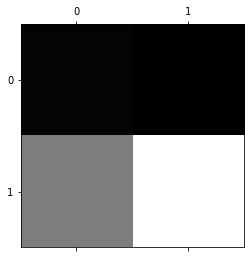

[[ 54  48]
 [236 431]]


In [45]:
cm = confusion_matrix(x_test['Food Safety Issue'],y_pred_test_rfc)
plt.matshow(cm, cmap=plt.cm.gray)
plt.show()
print(cm)

In [46]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(x_test['Food Safety Issue'],y_pred_test_rfc))

0.587794338125055


In [0]:
txt_vec_sub = MeanEmbeddingVectorizer(w2v_v2,'text token').transform(test)
title_vec_sub = MeanEmbeddingVectorizer(w2v_v2,'title token').transform(test)
prod_vec_sub = MeanEmbeddingVectorizer(w2v_v2,'product title token').transform(test)
adj_vec_sub = MeanEmbeddingVectorizer(w2v_v2,'adj token').transform(test)
nom_vec_sub = np.array(test[nominal_cols])
tdidf_vec_sub = tfidf.transform(test['text string']).toarray()
sub_feat = np.concatenate((txt_vec_sub, title_vec_sub, prod_vec_sub, adj_vec_sub, nom_vec_sub,tdidf_vec_sub), axis = 1)

In [0]:
######################### Optimization for RFC #########################################

In [49]:
max_feat_list = ['log2',None]
depth_list = [3,5,7]
for j in range(len(max_feat_list)):
    for i in range(len(depth_list)):
        rfc_clf = RandomForestClassifier(n_estimators=50, class_weight = 'balanced', max_depth = depth_list[i] 
                                         ,max_features = max_feat_list[j], bootstrap = True)
        rfc_clf.fit(x_train_feat, x_train['Food Safety Issue'])
        y_pred_test_rfc = rfc_clf.predict(x_test_feat)
        print(max_feat_list[j],depth_list[i])
        print(roc_auc_score(x_test['Food Safety Issue'],y_pred_test_rfc))

log2 3
0.5705529588147102
log2 5
0.5626451480142282
log2 7
0.5820766087544463
None 3
0.6133403886292148
None 5
0.5797101449275364
None 7
0.5530029103095512


In [0]:
########################### Optimization for Logit ############################################

In [51]:
c_list = [.001, .01, .1, 1.0, 10.0, 100.0]
for i in range(len(c_list)):
    log_clf = LogisticRegression(penalty = 'l2', C = c_list[i], class_weight = 'balanced')
    log_clf.fit(x_train_feat, x_train['Food Safety Issue'])
    y_pred_test_log = log_clf.predict(x_test_feat)
    print(c_list[i])
    print(roc_auc_score(x_test['Food Safety Issue'],y_pred_test_log))

0.001
0.6282226533791928
0.01
0.5847370432430843
0.1
0.545058353176353
1.0
0.5305215039539054
10.0
0.50018373166358
100.0
0.4982214774965459


In [0]:
################################# Final Prediction #######################################

In [0]:
txt_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'text token').transform(train)
title_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'title token').transform(train)
prod_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'product title token').transform(train)
adj_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'adj token').transform(train)
nom_vec_full_train = np.array(train[nominal_cols])
tdidf_vec_full_train = tfidf.transform(train['text string']).toarray()
train_feat = np.concatenate((txt_vec_full_train, title_vec_full_train, prod_vec_full_train, adj_vec_full_train, nom_vec_full_train, tdidf_vec_full_train), axis = 1)

In [54]:
rfc_clf = RandomForestClassifier(n_estimators=500, class_weight = 'balanced', max_depth = 3, max_features = None, bootstrap = True)
rfc_clf.fit(train_feat,train['Food Safety Issue'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
submission_test_rfc = rfc_clf.predict(sub_feat)
submission_test_rfc_prob = rfc_clf.predict_proba(sub_feat)

In [0]:
### Bootstrapping logit
sub_test_log_list = []
for i in range(0,100):
    boot_train = train.sample(frac = 1.0, replace = True)
    txt_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'text token').transform(boot_train)
    title_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'title token').transform(boot_train)
    prod_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'product title token').transform(boot_train)
    adj_vec_full_train = MeanEmbeddingVectorizer(w2v_v2,'adj token').transform(boot_train)
    nom_vec_full_train = np.array(boot_train[nominal_cols])	
    tdidf_vec_full_train = tfidf.transform(boot_train['text string']).toarray()

    train_feat = np.concatenate((txt_vec_full_train, title_vec_full_train, prod_vec_full_train, adj_vec_full_train, nom_vec_full_train, tdidf_vec_full_train), axis = 1)
    log_clf = LogisticRegression(penalty = 'l2', C = .01, class_weight = 'balanced')
    log_clf.fit(train_feat,boot_train['Food Safety Issue'])
    submission_test_log = log_clf.predict(sub_feat)
    submission_test_log_prob = log_clf.predict_proba(sub_feat)
    sub_test_log_list.append(submission_test_log_prob[:,1])

In [0]:
avg_logit_pred = np.mean(np.array(sub_test_log_list), axis = 0).tolist()

In [0]:
submission_test_final = []
for i in range(len(submission_test_rfc_prob)):
    final_proba = submission_test_rfc_prob[i][1]*0.5 + avg_logit_pred[i]*0.5
    if final_proba >= 0.5:
        submission_test_final.append(1)
    else:
        submission_test_final.append(0)

In [0]:
test['Food Safety Issue'] = submission_test_final
test[['ID','Food Safety Issue']].to_csv('submission.csv')

In [0]:
######################################## Quick Test a few models to ensemble the RFC with #####################################

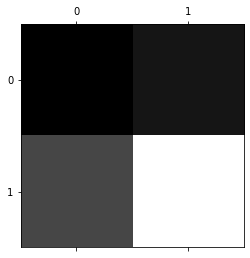

[[ 31  71]
 [162 505]]
0.5305215039539054


In [61]:
## logit works ##

log_clf = LogisticRegression(penalty = 'l2', C = 1.0, class_weight = 'balanced')
log_clf.fit(x_train_feat, x_train['Food Safety Issue'])
y_pred_test_log = log_clf.predict(x_test_feat)
cm = confusion_matrix(x_test['Food Safety Issue'],y_pred_test_log)
plt.matshow(cm, cmap=plt.cm.gray)
plt.show()
print(cm)
print(roc_auc_score(x_test['Food Safety Issue'],y_pred_test_log))

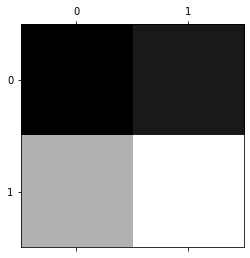

[[ 33  69]
 [279 388]]
0.4526192785959961


In [62]:
## NB is poop
nb_clf = GaussianNB()
nb_clf.fit(x_train_feat, x_train['Food Safety Issue'])
y_pred_test_nb = nb_clf.predict(x_test_feat)
cm = confusion_matrix(x_test['Food Safety Issue'],y_pred_test_nb)
plt.matshow(cm, cmap=plt.cm.gray)
plt.show()
print(cm)
print(roc_auc_score(x_test['Food Safety Issue'],y_pred_test_nb))

In [0]:
########################################## Exploration Stuff ##################################################################

In [0]:
## Create full text
	
df_bad = train.loc[train['Food Safety Issue']==1]
bad_text_list = []
for i in range(len(df_bad['text token'])):
    row = np.asarray(df_bad['text token'])[i]
    for j in range(len(row)):	
        bad_text_list.append(row[j])

df_good = train.loc[train['Food Safety Issue']==0]
good_text_list = []
for i in range(len(df_good['text token'])):
    row = np.asarray(df_good['text token'])[i]
    for j in range(len(row)):
        good_text_list.append(row[j])

In [65]:
#### Using vader to see if sentiment on review title helps
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores(train['Review Title'][0])
print(ss)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [66]:
## Tuples of word counter -- I want to find the most common negative and positive words related to food safety issue
## Include "not" so we can know not good --> bad, not stale --> good
import collections
counter = collections.Counter(bad_text_list)
print(counter.most_common())

[('not', 1901), ('stale', 1289), ('br', 1116), ("n't", 899), ('product', 869), ('like', 710), ('taste', 631), ('one', 496), ('would', 418), ('good', 418), ("'s", 398), ('bag', 351), ('box', 344), ('tasted', 339), ('buy', 331), ('bad', 321), ('time', 304), ('received', 287), ('flavor', 277), ('disappointed', 276), ('old', 273), ('get', 267), ('date', 266), ('first', 259), ('really', 257), ('rancid', 252), ('got', 251), ('arrived', 251), ('could', 250), ('even', 245), ('package', 244), ('opened', 243), ("'m", 242), ('made', 237), ('order', 235), ('mold', 234), ('return', 233), ('bought', 232), ('hard', 228), ('also', 224), ('ordered', 222), ('amazon', 219), ('coffee', 217), ('never', 210), ('away', 204), ('sick', 202), ('tried', 200), ('use', 198), ('candy', 198), ('two', 197), ('eat', 196), ('broken', 194), ('money', 192), ('nuts', 189), ('love', 189), ('great', 187), ('fresh', 176), ("'ve", 174), ('food', 171), ('chocolate', 171), ('tastes', 171), ('however', 169), ('sure', 165), ('use

In [67]:
counter = collections.Counter(good_text_list)
print(counter.most_common())

[('not', 408), ('br', 325), ("n't", 232), ('stale', 167), ('like', 163), ('taste', 138), ('product', 124), ('one', 123), ("'s", 123), ('good', 116), ('would', 102), ("'m", 84), ('coffee', 83), ('get', 80), ('bag', 80), ('flavor', 70), ('amazon', 70), ('box', 66), ('time', 65), ('even', 64), ("'ve", 61), ('bought', 61), ('first', 60), ('much', 59), ('tea', 56), ('use', 55), ('could', 55), ('buy', 53), ('disappointed', 52), ('really', 52), ('sugar', 51), ('order', 51), ('also', 50), ('got', 50), ('love', 49), ('tried', 48), ('great', 48), ('tasted', 48), ('sealed', 48), ('bad', 47), ('used', 46), ('package', 44), ('ordered', 44), ('eat', 42), ('chocolate', 42), ('price', 42), ('try', 41), ('fresh', 41), ('received', 40), ('make', 40), ('better', 40), ('little', 40), ('made', 39), ('never', 39), ('oil', 39), ('broken', 38), ('two', 38), ('know', 37), ('purchased', 37), ('money', 37), ('ca', 36), ('came', 36), ('candy', 36), ('old', 36), ('item', 34), ('arrived', 34), ('nuts', 34), ('opene

In [68]:
train.head()

,ID,Product ASIN,Review star rating,Food Safety Issue,Review Text,Review Title,@nlp.sentenceCount,@product.brand,@product.countryOfOrigin,Product Width,Product Length,Product Height,Timestamp,Product Title (Analyzed),text token,title token,brand token,product title token,adj token,has stale,has not,has disappointed,has good,has great,pos,neg,neu,text string
0,2959,B016YOCSIC,1,1,yes best brownie i ever had sugar or no bu...,diabetics beware,8,diabetic kitchen,NaN,4.1,4.1,4.7,2017-11-12 14:04:00,diabetic kitchen gourmet chocolate brownie mix...,"[yes, best, brownie, ever, sugar, really, rais...","[diabetics, beware]","[diabetic, kitchen]","[diabetic, kitchen, gourmet, chocolate, browni...","[best, type, diabetic, diet, low, higher, fat,...",0,1,0,0,0,0.000,0.0,1.000,yes best brownie ever sugar really raised bloo...
1,2377,B019T1K5Z0,3,1,much smaller bag then anticipated and were a ...,much smaller bag then anticipated and were a b...,2,necco,NaN,NaN,NaN,NaN,2017-11-10 21:31:00,necco original classic small conversation hear...,"[much, smaller, bag, anticipated, bit, stale]","[much, smaller, bag, anticipated, bit, stale]",[necco],"[necco, original, classic, small, conversation...","[much, smaller, stale]",1,0,0,0,0,0.000,0.0,1.000,much smaller bag anticipated bit stale
2,2505,B018XVZQRE,1,1,both bags were staled when we got them,one star,2,pipcorn,NaN,NaN,NaN,NaN,2017-12-15 18:22:00,pipcorn truffle mini popcorn oz,"[bags, staled, got]","[one, star]",[pipcorn],"[pipcorn, truffle, mini, popcorn, oz]",[],0,0,0,0,0,0.000,0.0,1.000,bags staled got
3,117,B00NZATP8K,1,1,worst candy corn ever it was stale and gross ...,one star,4,hoosier hill farm,NaN,NaN,NaN,NaN,2017-11-03 03:58:00,hoosier hill farm premium candy corn lbs,"[worst, candy, corn, ever, stale, gross, total...","[one, star]","[hoosier, hill, farm]","[hoosier, hill, farm, premium, candy, corn, lbs]","[worst, stale, gross, total]",1,0,0,0,0,0.000,0.0,1.000,worst candy corn ever stale gross total waste ...
4,4378,B00NG6PWPS,3,0,when we can get a cup of this coffee to brew ...,it is very good out of cups we have tried t...,6,crazy cups,US,4.5,8.0,6.0,2017-11-03 17:44:00,crazy cups coffee chocolate lovers single serv...,"[get, cup, coffee, brew, good, cups, tried, br...","[good, cups, tried]","[crazy, cups]","[crazy, cups, coffee, chocolate, lovers, singl...","[good, recent, needle, other, same, least]",0,0,0,1,0,0.242,0.0,0.758,get cup coffee brew good cups tried brew recen...
